# Input variables:
   ### Bank Client data:
   1 - age (numeric)
   
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   
   5 - default: has credit in default? (categorical: "no","yes","unknown")
   
   6 - housing: has housing loan? (categorical: "no","yes","unknown")
   
   7 - loan: has personal loan? (categorical: "no","yes","unknown")
   ### Related with the last contact of the current campaign:
   8 - contact: contact communication type (categorical: "cellular","telephone") 
   
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  
  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
   ### Other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  
  14 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
  
   ### Social and economic context attributes
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
  
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  
  20 - nr.employed: number of employees - quarterly indicator (numeric)

  ### Output variable (desired target):
  
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")

### Importing all the necessary libraries

In [106]:
import pandas as pd
pd.set_option ( "display.max_rows" , None )
pd.set_option ( "display.max_columns" , None )
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings ( "ignore" )

### Loading the dataset

In [107]:
data = pd.read_csv ( "bank-additional-full.csv" , sep = ";" )
data.head ( )

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Information about the dataset

In [108]:
# Number of Records and Features
print ( "Rows:" , data.shape [ 0 ] )
print ( "Features:" , data.shape [ 1 ] )

Rows: 41188
Features: 21


In [109]:
# Feature names with their data types and null values (if any)
pd.DataFrame ( { "Feature" : data.columns , "Data Type" : list ( data.dtypes ) , 
               "Null Values" : list ( data.isnull ( ).sum ( ) ) } )

,Feature,Data Type,Null Values
0,age,int64,0
1,job,object,0
2,marital,object,0
3,education,object,0
4,default,object,0
5,housing,object,0
6,loan,object,0
7,contact,object,0
8,month,object,0
9,day_of_week,object,0


In [110]:
# Splitting continuous and categorical feature names
categorical = data.select_dtypes ( include = "O" ).columns
continuous = data.select_dtypes ( exclude = "O" ).columns

In [111]:
# Description of categorical features
data [ categorical ].describe ( )

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [112]:
# Description of continuous features
data [ continuous ].describe ( )

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Univariate Analysis

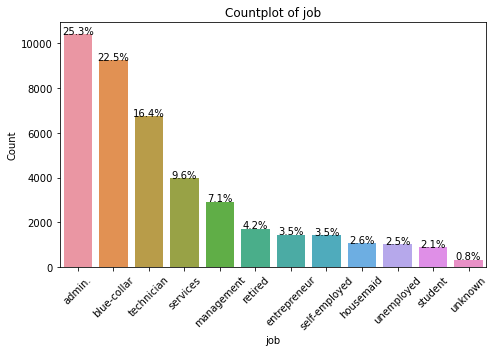

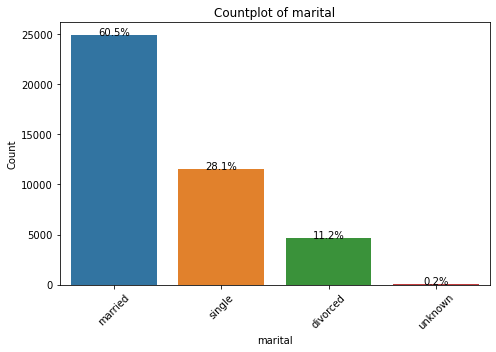

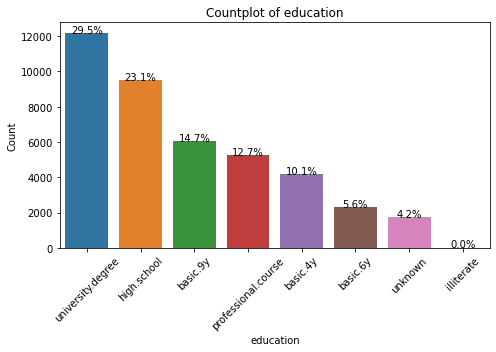

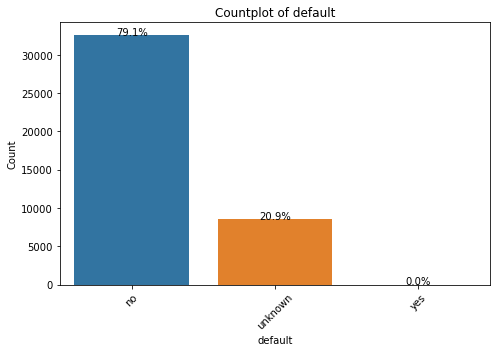

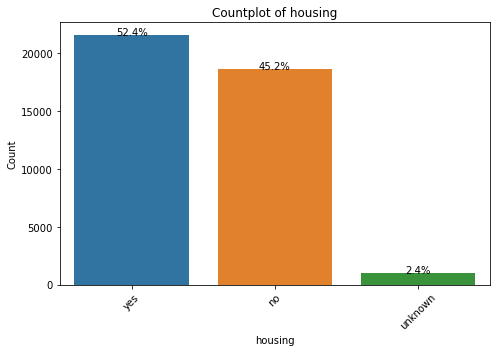

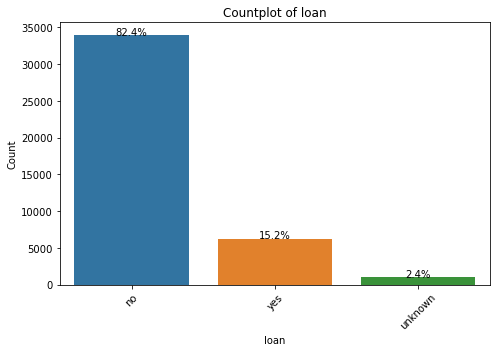

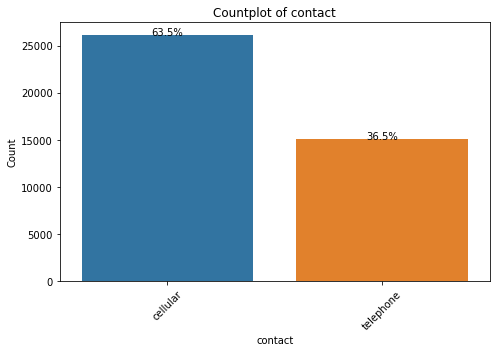

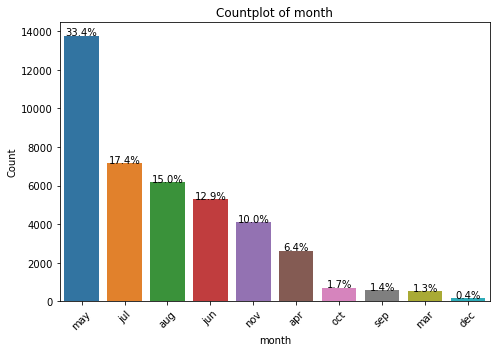

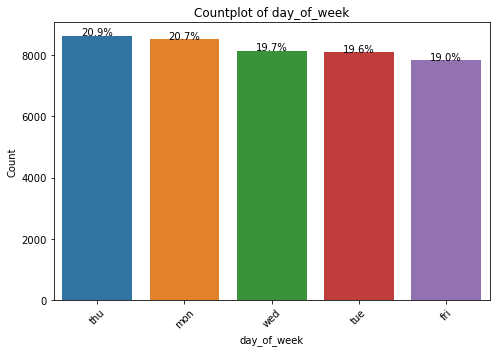

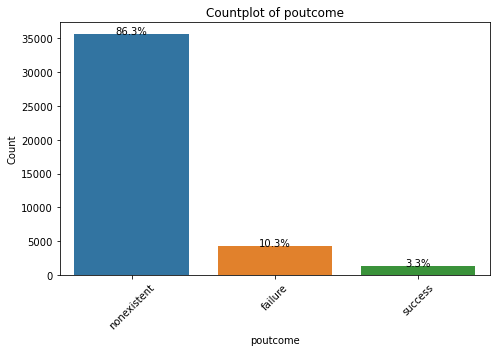

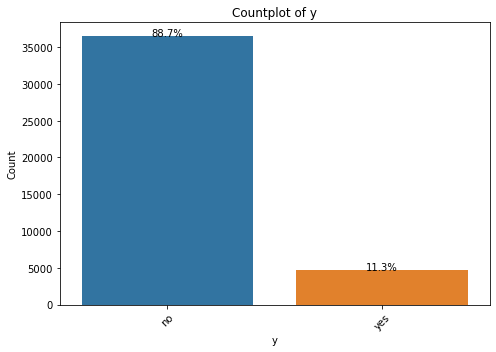

In [113]:
# Understanding the categorical variables
for feature in categorical:
    plt.rcParams [ "figure.figsize" ] = [ 7 , 5 ]
    plt.rcParams [ "figure.autolayout" ] = True

    counts = data [ feature ].value_counts ( )
    ax = sns.barplot ( x = counts.index  , y = list ( counts ) )
    percentage = list ( np.array ( list ( counts ) ) / data.shape [ 0 ] * 100 )
    patches = ax.patches
    for i in range ( len ( patches ) ):
        x = patches [ i ].get_x ( ) + patches [ i ].get_width ( ) / 2
        y = patches [ i ].get_height ( ) + 0.05
        ax.annotate ( '{:.1f}%' .format ( percentage [ i ] ) 
                     , ( x , y ) , ha = 'center' )
    plt.title ( "Countplot of " + feature )
    plt.xlabel ( feature )
    plt.ylabel ( "Count" )
    plt.xticks ( rotation = 45 )
    plt.show()

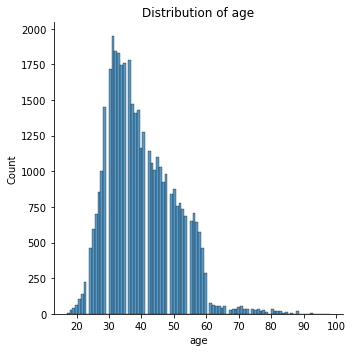

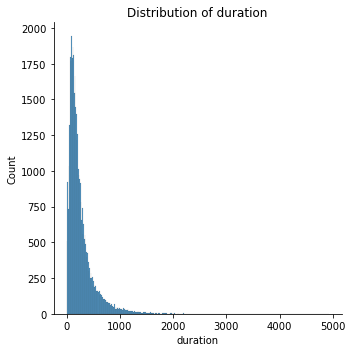

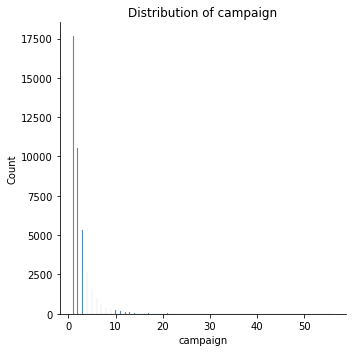

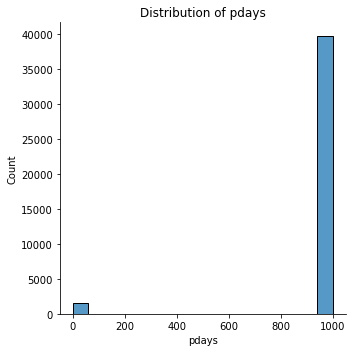

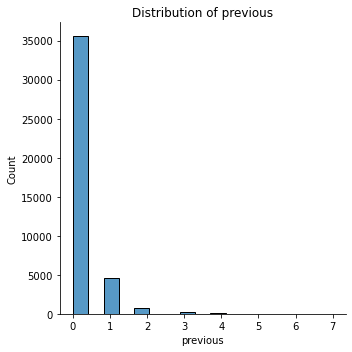

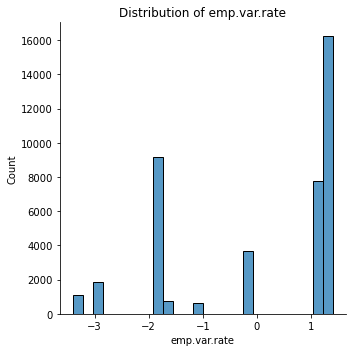

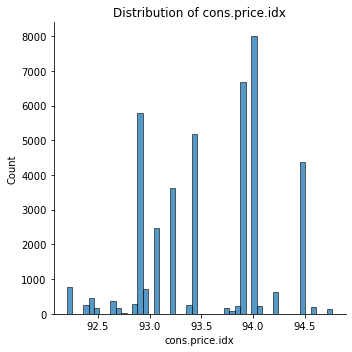

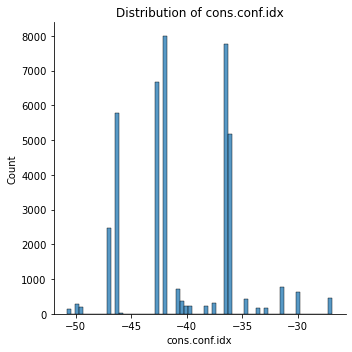

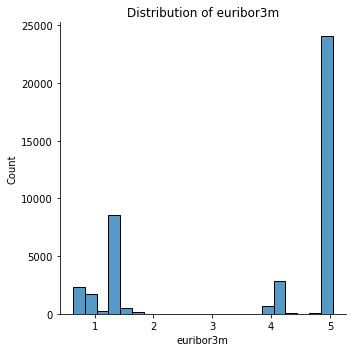

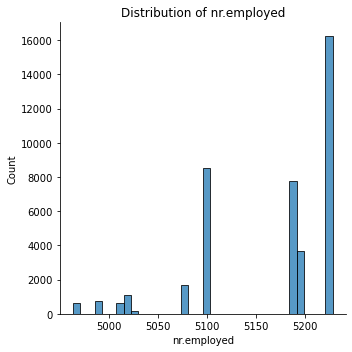

In [114]:
# Understanding the continuous variable
for feature in continuous:
    sns.displot ( data [ feature ] )
    plt.title ( "Distribution of " + feature )
    plt.show ( )

### Feature comparison with respect to target variable "y"

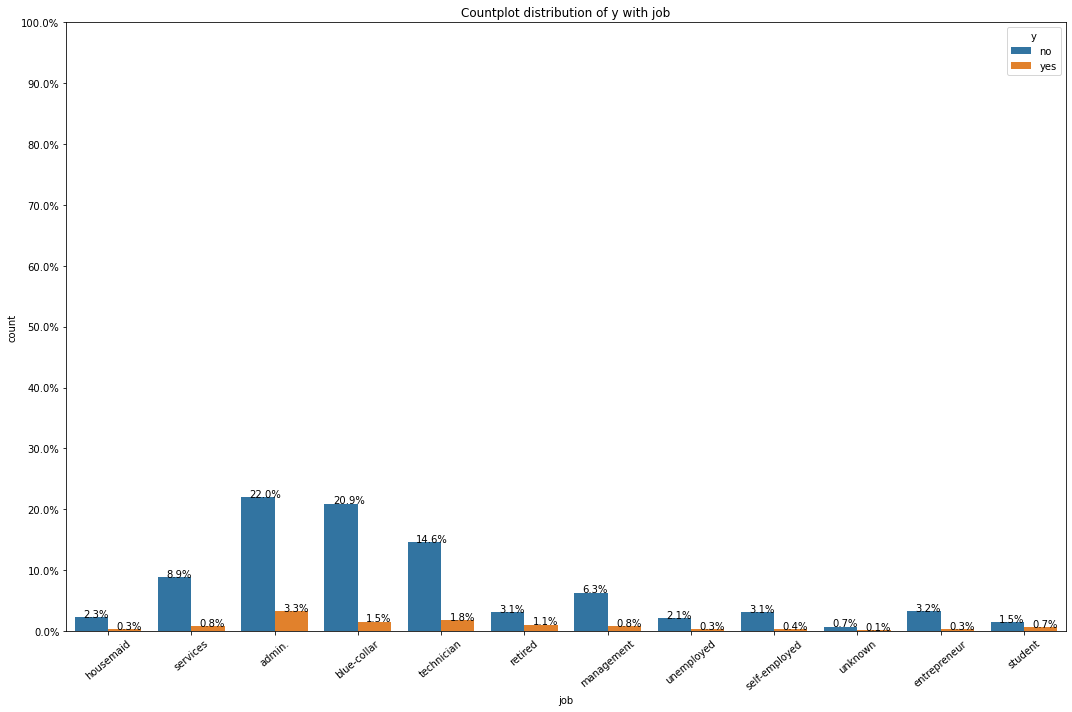

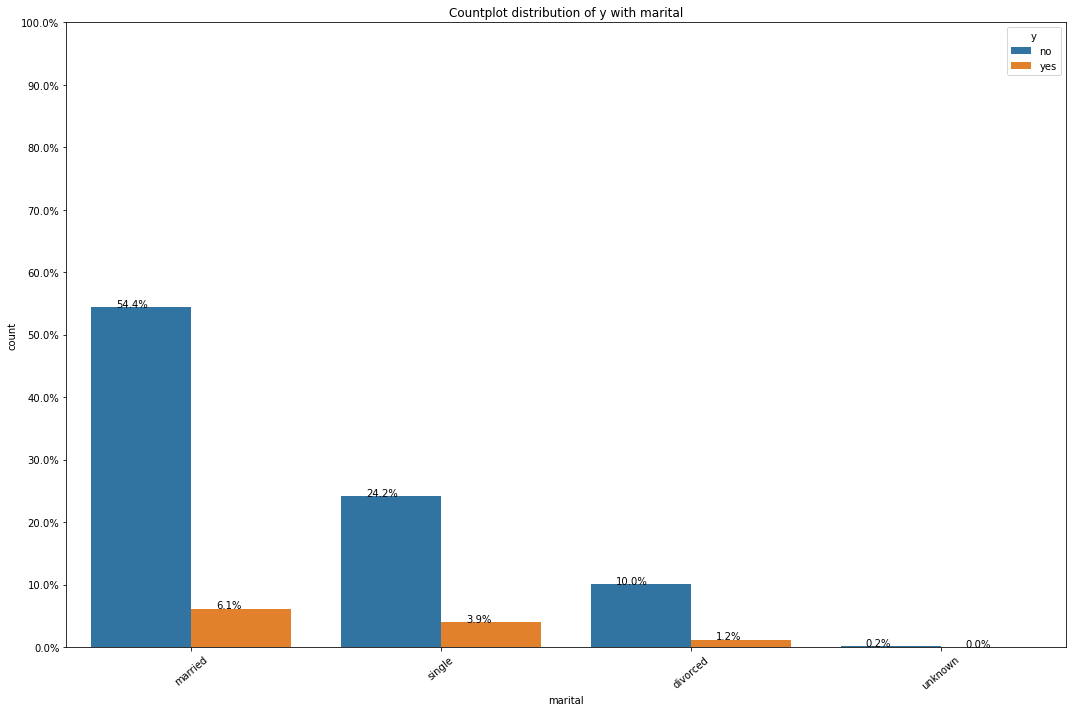

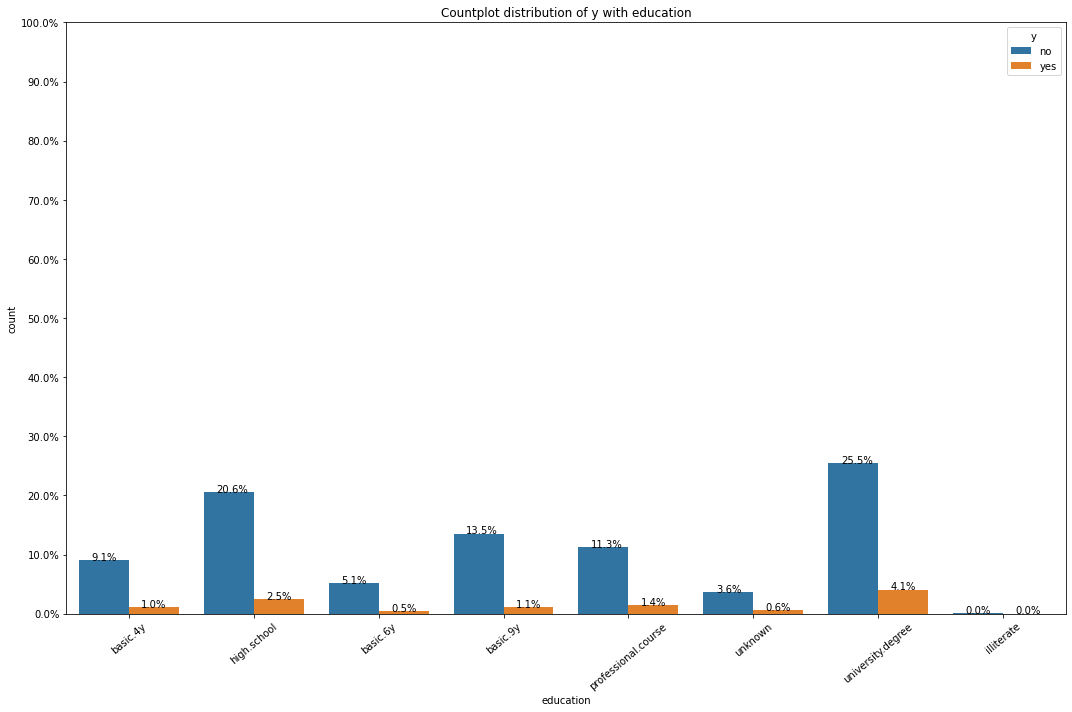

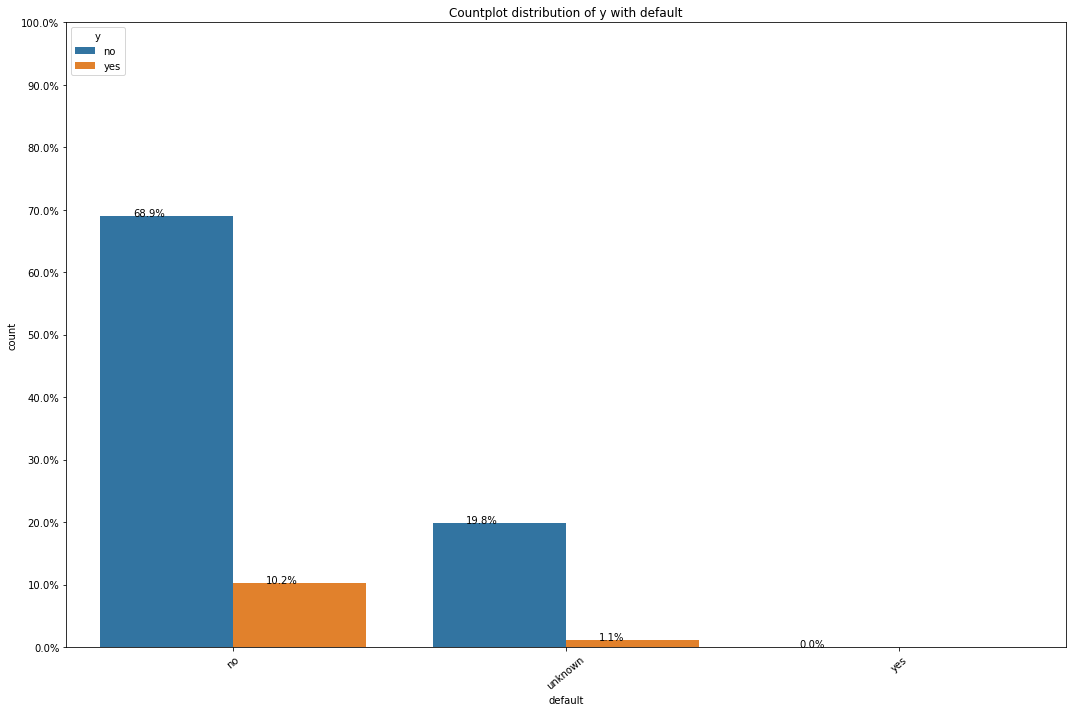

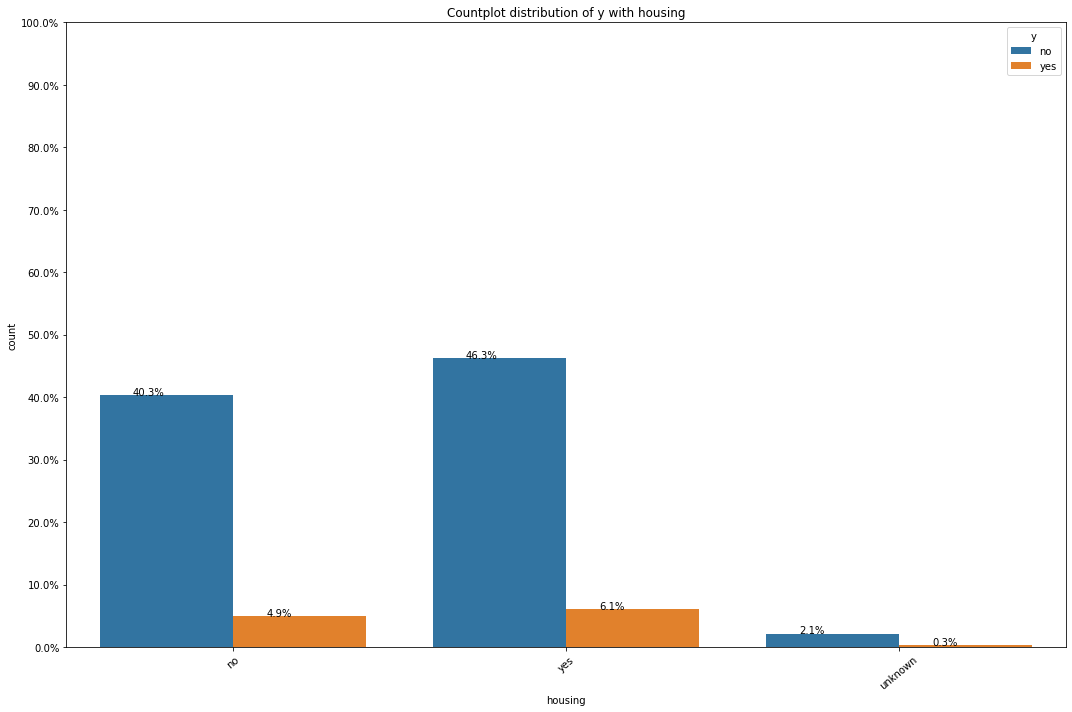

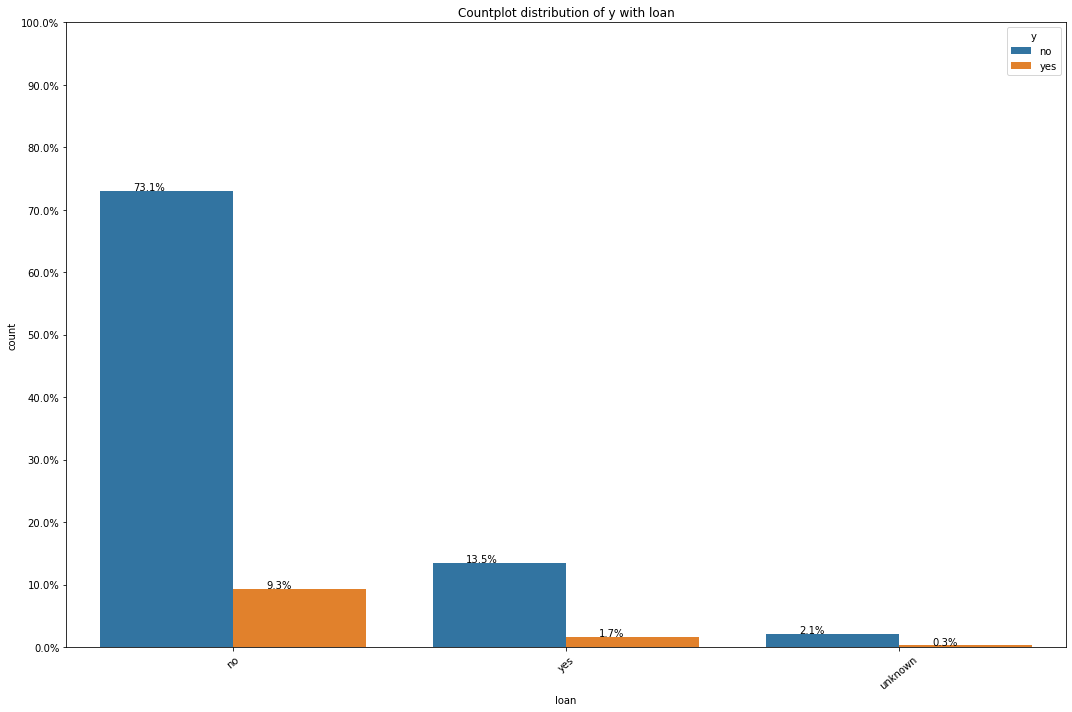

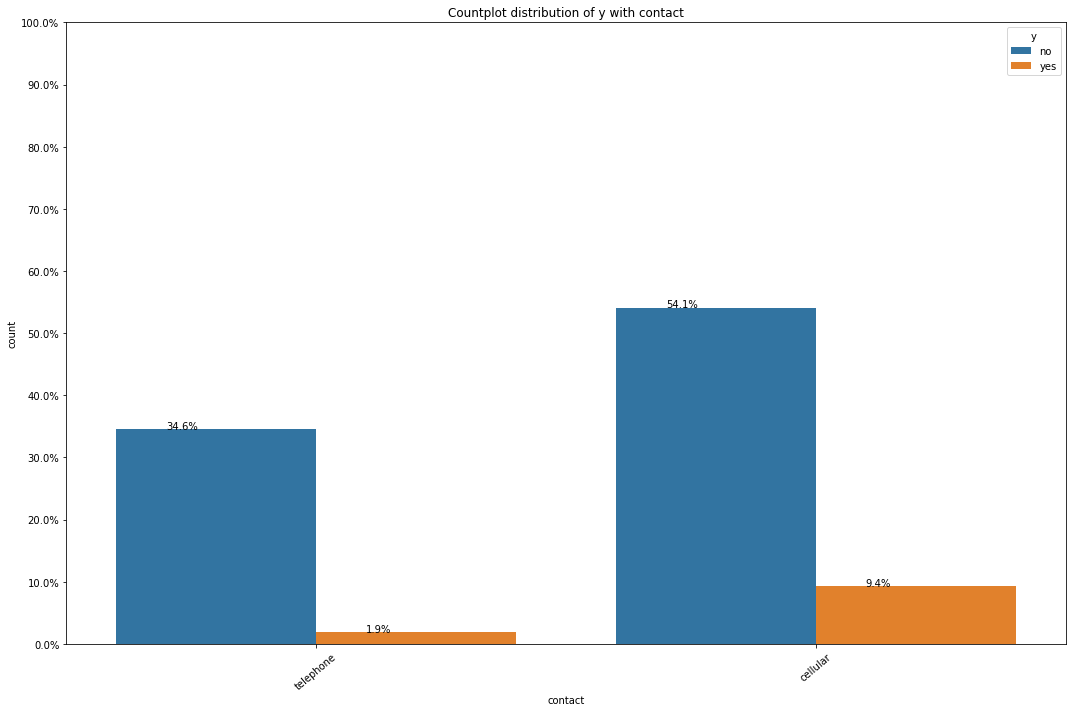

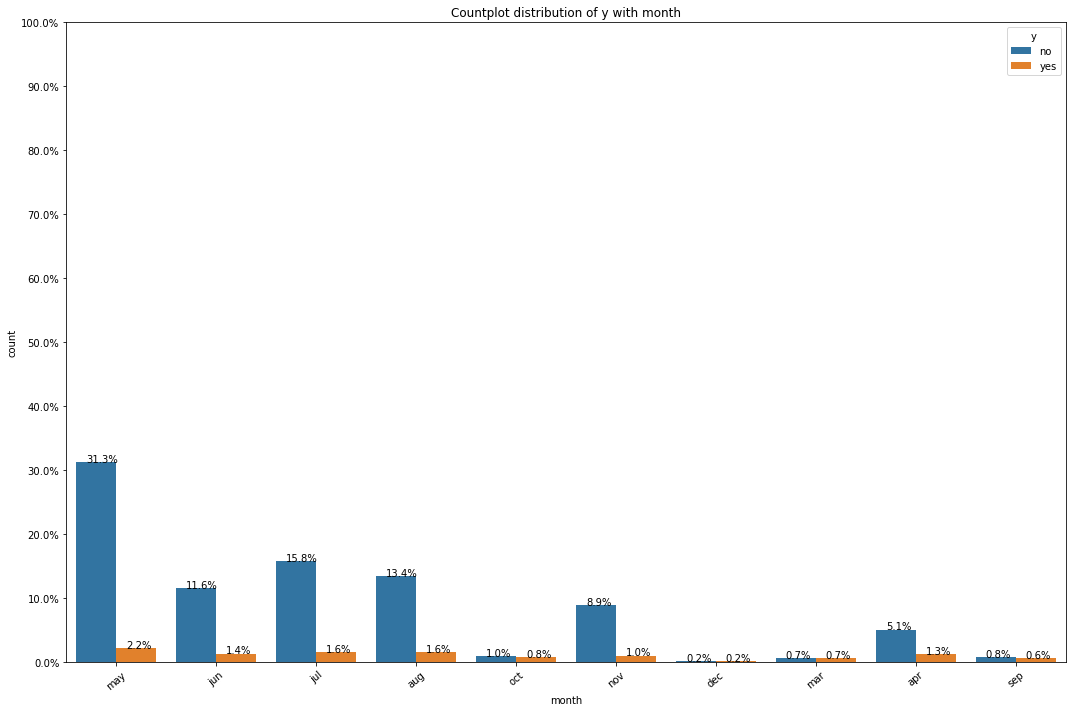

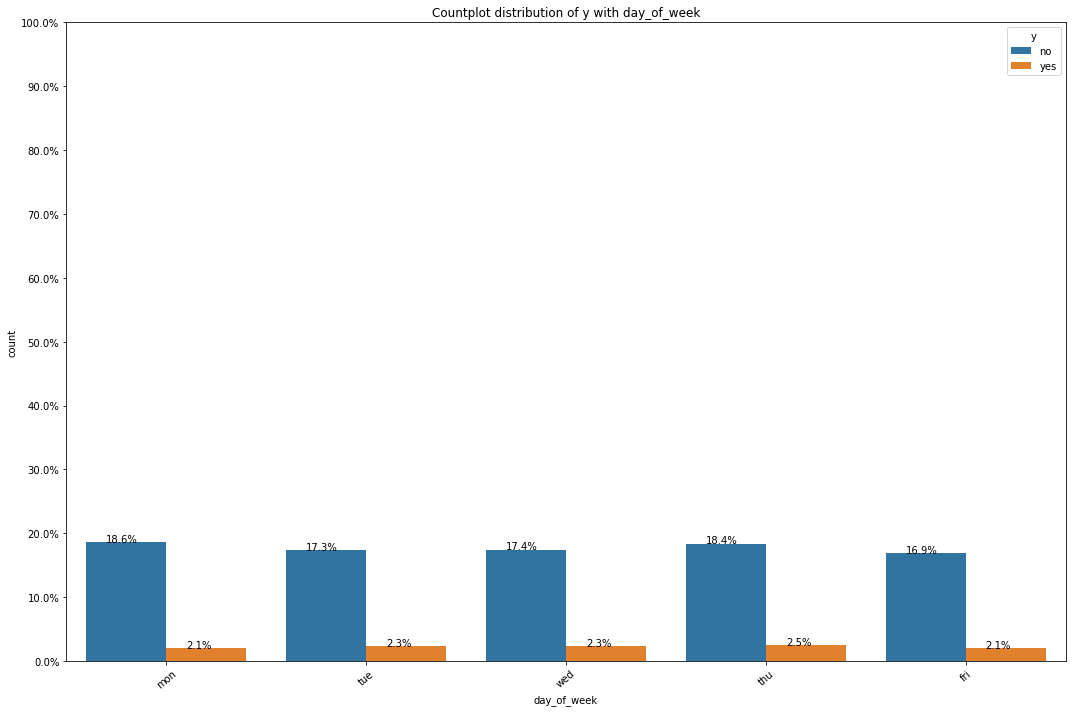

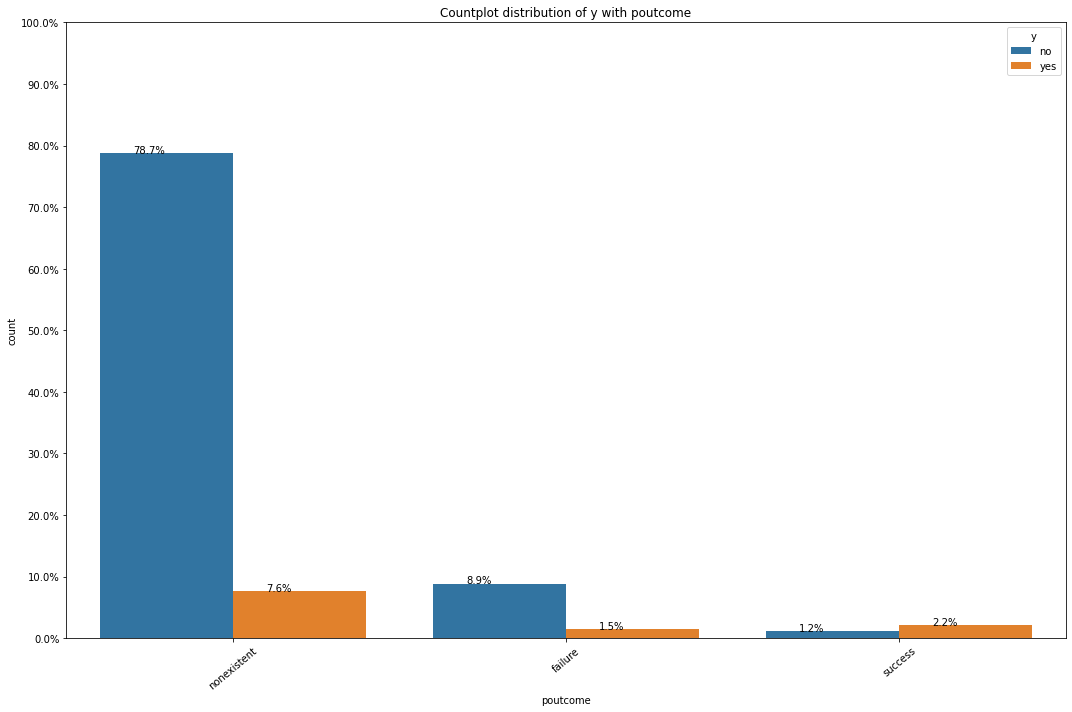

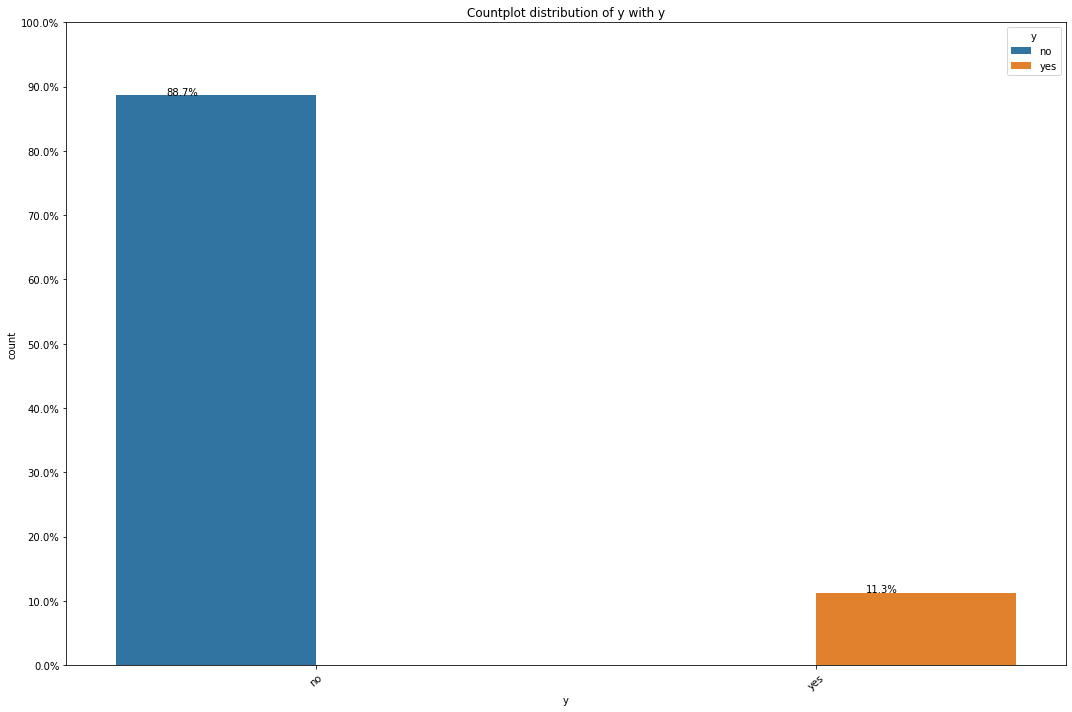

In [115]:
for feature in categorical:
    plt.figure ( figsize = ( 15 , 10 ) )
    Y = data [ feature ]
    total = len ( Y ) * 1.
    ax = sns.countplot ( x = feature , data = data , hue = "y" )
    for p in ax.patches:
        ax.annotate ( '{:.1f}%' .format ( 100*p.get_height ( ) / total ) , 
                     ( p.get_x ( ) + 0.1 , p.get_height ( ) + 5 ) )
    ax.yaxis.set_ticks ( np.linspace ( 0 , total , 11 ) )
    ax.set_yticklabels ( map ( '{:.1f}%' .format , 100 * ax.yaxis.get_majorticklocs ( ) / total ) )
    ax.set_xticklabels ( ax.get_xticklabels ( ) , rotation = 40 , ha = "center" )
    plt.title ( "Countplot distribution of y with " + feature )
    plt.show ( )

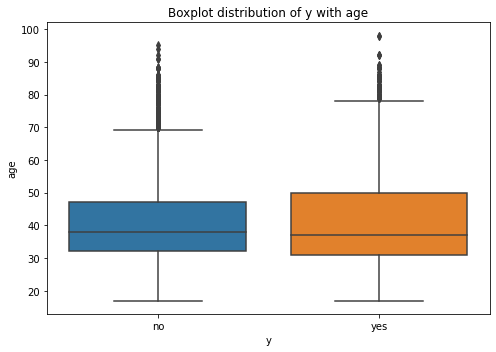

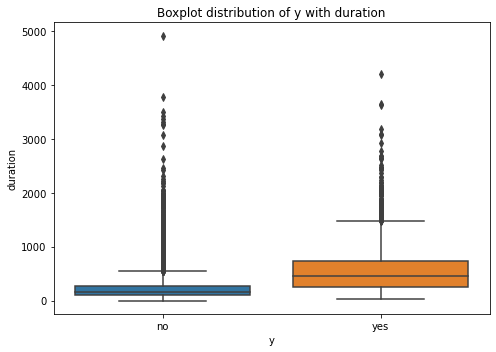

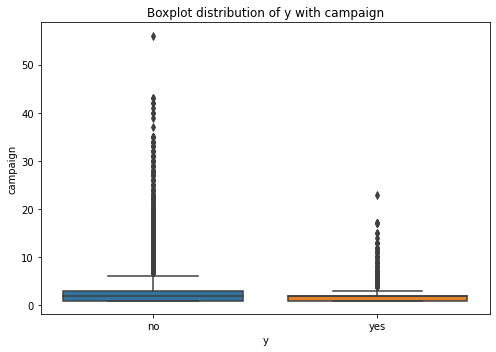

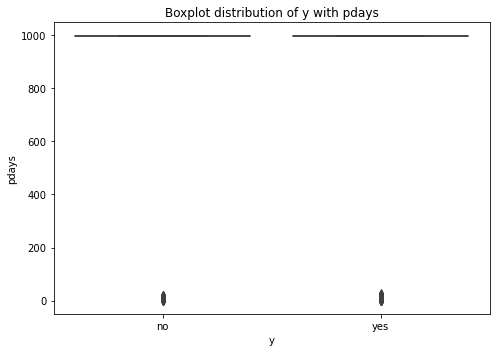

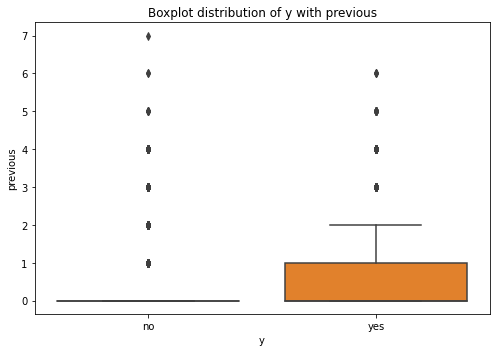

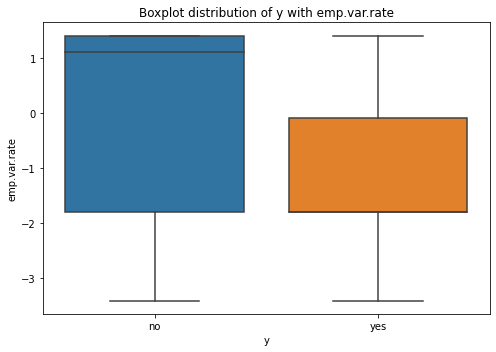

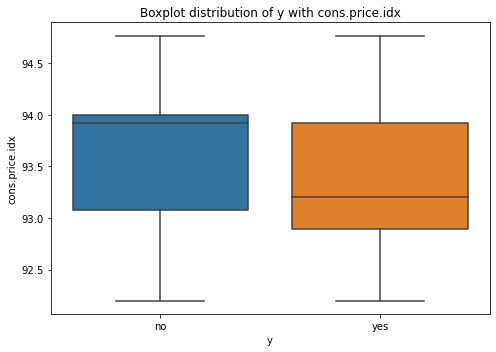

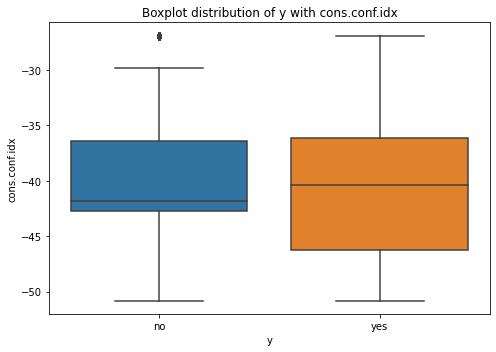

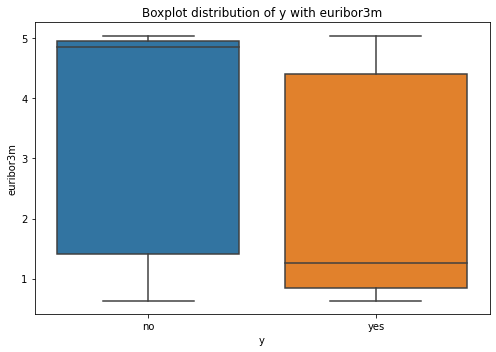

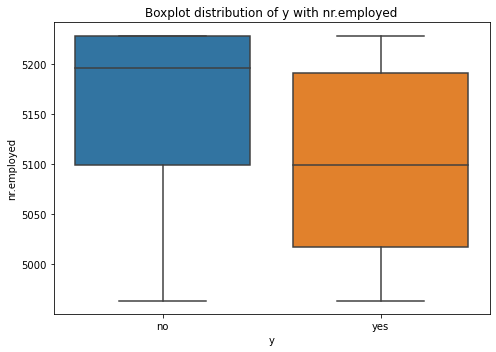

In [116]:
for feature in continuous:
    sns.boxplot ( y = data [ feature ] , x = data [ "y" ] )
    plt.title ( "Boxplot distribution of y with " + feature )
    plt.show ( )

### Correlation Matrix

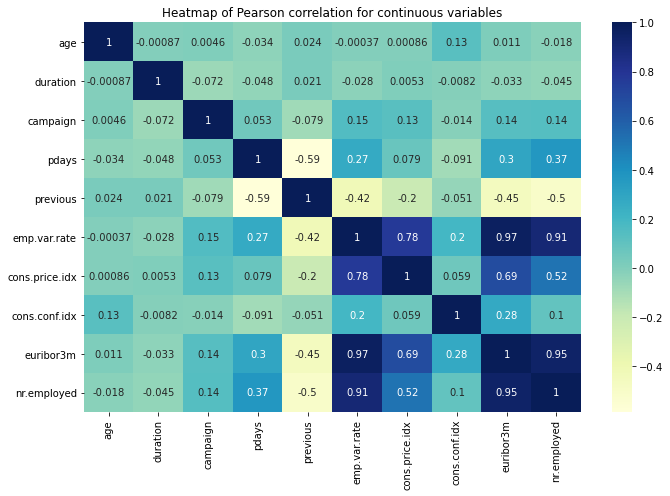

In [117]:
# Finding Pearson correlation for continuous variables
plt.figure ( figsize = ( 10 , 7 ) )
sns.heatmap ( data [ continuous ].corr ( method = "pearson" ) , annot = True , cmap = "YlGnBu" )
plt.title ( "Heatmap of Pearson correlation for continuous variables" )
plt.show ( )

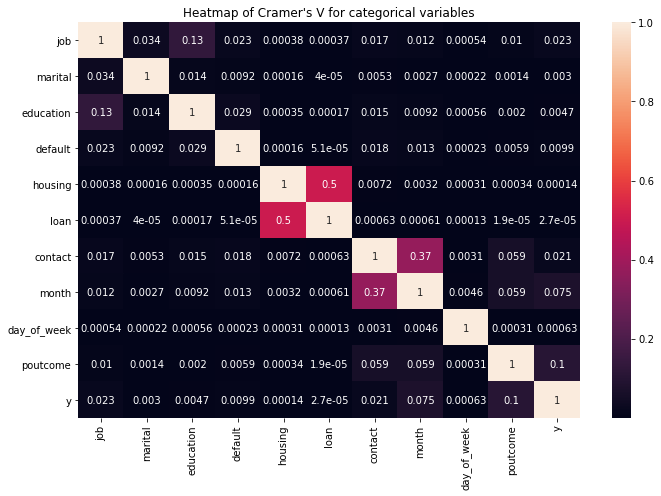

In [118]:
# Finding Cramer's V for categorical variables
def cramers_V ( feature1 , feature2 ):
    crosstab = pd.crosstab ( feature1 , feature2 )
    chi2_statistic = chi2_contingency ( crosstab ) [ 0 ]
    obs = sum ( np.sum ( crosstab ) )
    minimum = min ( crosstab.shape ) - 1 
    return ( chi2_statistic / ( obs * minimum ) )

columns = [ ]
for feature1 in data [ categorical ]:
    rows = [ ]
    for feature2 in data [ categorical ]:
        cramers = cramers_V ( data [ feature1 ] , data [ feature2 ] )
        rows.append ( cramers )
    columns.append ( rows )
results = np.array ( columns )
df = pd.DataFrame ( index = data [ categorical ].columns , columns = data [ categorical ].columns , 
                  data = results )

plt.figure ( figsize = ( 10 , 7 ) )
sns.heatmap ( df , annot = True )
plt.title ( "Heatmap of Cramer's V for categorical variables" )
plt.show ( )

### Pre-Processing

In [119]:
# Finding redundant data
print ( "Duplicate rows: " , data [ data.duplicated ( keep = "first" ) ].shape [ 0 ] )

Duplicate rows:  12


### VIF for continuous variables

In [120]:
vif_data = pd.DataFrame ( )
vif_data [ "Features" ] = data [ continuous ].columns
  
vif_data [ "VIF" ] = [ variance_inflation_factor ( data [ continuous ].values, i ) for i in range ( len ( data [ continuous ].columns ) ) ]
vif_data

,Features,VIF
0,age,16.047296
1,duration,2.011044
2,campaign,1.921499
3,pdays,44.413175
4,previous,2.001464
5,emp.var.rate,28.910219
6,cons.price.idx,22561.123124
7,cons.conf.idx,120.086975
8,euribor3m,226.237349
9,nr.employed,26746.634212


### Splitting the data into X (Independent variables) and y (dependent variable) and performing a train-test split


In [121]:
X , y  = data.drop ( "y" , axis = 1 ) , data [ "y" ]
print ( "Dimensions of X:" , X.shape )
print ( "Dimensions of y:" , y.shape )

X_train_valid , X_test , y_train_valid , y_test = train_test_split ( X , y ,  test_size = 0.2 , random_state = 37 )
X_train , X_valid , y_train , y_valid = train_test_split ( X_train_valid , y_train_valid ,  test_size = 0.2 , random_state = 37 )

print ( "X_train:" , X_train.shape )
print ( "y_train:" , y_train.shape )
print ( "X_test:" , X_test.shape )
print ( "y_test" , y_test.shape )
print ( "X_valid:" , X_valid.shape )
print ( "y_valid:" , y_valid.shape )

Dimensions of X: (41188, 20)
Dimensions of y: (41188,)
X_train: (26360, 20)
y_train: (26360,)
X_test: (8238, 20)
y_test (8238,)
X_valid: (6590, 20)
y_valid: (6590,)


### Replacing "no" with 0s and "yes" with 1s

In [122]:
y_train.replace ( { "no" : 0 , "yes" : 1 } , inplace = True )
y_test.replace ( { "no" : 0 , "yes" : 1 } , inplace = True )
y_valid.replace ( { "no" : 0 , "yes" : 1 } , inplace = True )

### Using CountVectorizer to get all the one hot encoded columns

In [123]:
categorical = list ( categorical )
categorical.remove ( "y" )

In [124]:
def OneHotEncoder ( categorical , train , test , valid ):
    for column in categorical:
        vectorizer = CountVectorizer ( token_pattern = "[A-Za-z0-9-.]+" )
        print ( "Encoding for {}..." .format ( column ) )
        cols = vectorizer.fit_transform ( train [ column ] )
        X_train = OneHotEncodedDataFrame ( cols , train , vectorizer , column )

        cols = vectorizer.transform ( test [ column ] )
        X_test = OneHotEncodedDataFrame ( cols , test , vectorizer , column )

        cols = vectorizer.transform ( valid [ column ] )
        X_valid = OneHotEncodedDataFrame ( cols , valid , vectorizer , column )

def OneHotEncodedDataFrame ( cols , df , vectorizer , column ):
    for i , col in enumerate ( vectorizer.get_feature_names ( ) ):
        df [ col + "_" + column ] = cols [ : , i ].toarray ( ).ravel ( ).tolist ( )
    
    return df

OneHotEncoder ( categorical , X_train , X_test , X_valid )

X_train.drop ( categorical , axis = 1 , inplace = True )
X_valid.drop ( categorical , axis = 1 , inplace = True )
X_test.drop ( categorical , axis = 1 , inplace = True )

print ( "X_train:" , X_train.shape )
print ( "X_valid:" , X_valid.shape )
print ( "X_test:" , X_test.shape )

Encoding for job...
Encoding for marital...
Encoding for education...
Encoding for default...
Encoding for housing...
Encoding for loan...
Encoding for contact...
Encoding for month...
Encoding for day_of_week...
Encoding for poutcome...
X_train: (26360, 63)
X_valid: (6590, 63)
X_test: (8238, 63)
